In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import json
import requests
import matplotlib.pyplot as plt
import ast

PATH = './data'

# Importing CMU dataset

We import the CMU data and add the names of the columns by looking at the data documentation.

In [2]:
data_folder = './data/'

character = pd.read_csv(PATH + '/character.metadata.tsv', sep='\t', 
                        names=['wikiPageID', 'freebaseMovieId', 'DateOfRelease', 'characterName', 'actorDOB',
                               'actorGender', 'actorHeight', 'actorEthnicity', 'actorName', 
                               'actorAge', 'map1', 'map2', 'map3'])

movie = pd.read_csv(PATH + '/movie.metadata.tsv', sep='\t', 
                    names=['wikiPageID', 'freebaseMovieId', 'movieName', 'movieReleaseDate', 'movieBoxOfficeRevenue',
                            'movieRuntime', 'movieLanguages', 'movieCountries', 'movieGenres'])

# Merging additional dataset

Our initial data does not contain information about the budget of the movie. We will then use wikidata and merge it to our dataset.

### Utils

In [3]:
# Function to convert currency using exchange rate json file
def convert_to_usd(amount, currency):

    with open(f"{PATH}/usd_conversion_rates.json", 'r') as file:
        conversion_rates = json.load(file)

    rate = conversion_rates.get(currency, 1)  # Default to 1 if currency not found
    return float(amount) / float(rate)


def get_wikipedia_page_id(film_name):
    # Replace spaces with underscores for the Wikipedia API format
    film_name_formatted = film_name.replace(' ', '_')

    url = f"https://en.wikipedia.org/w/api.php"

    params = {
        'action': 'query',
        'format': 'json',
        'titles': film_name_formatted
    }

    response = requests.get(url, params=params)

    if response.status_code == 200:
        try:
            data = response.json()
            page_id = next(iter(data['query']['pages']))
            return page_id
        except KeyError:
            print(f"No page found for {film_name}")
            return None
    else:
        print("Failed to fetch data from Wikipedia")
        return None

### DATA PROCESSING AND CURRENCY CONVERSION

In [ ]:
# Read the data into a DataFrame
df = pd.read_csv(f"{PATH}/film_wiki_data.csv")

# Group by 'filmLabel' and keep the row with the max 'boxOffice' for each group since some films have multiple rows with box office per country
df = df.loc[df.groupby('filmLabel')['boxOffice'].idxmax()]
df = df.reset_index(drop=True)


def convert_row(row):
    if row['currencyCode'] != 'USD':
        row['cost'] = convert_to_usd(row['cost'], row['currencyCode'])
        row['boxOffice'] = convert_to_usd(row['boxOffice'], row['currencyCode'],)
        row['currencyCode'] = 'USD'

        # Fetch and add the Wikipedia page ID
    row['wikiPageID'] = get_wikipedia_page_id(row['filmLabel'])
    row['costBoxOfficeMultiplier'] = row['boxOffice'] / row['cost']

    return row

# Apply the conversion to each row
df = df.apply(convert_row, axis=1)

# remove if page id is not defined
df = df[df['wikiPageID'] != -1]
# save csv without row index
df.to_csv(f'{PATH}/film_wiki_data_formatted.csv', index=False)

### MERGE DATASETS

In [4]:
# Load the first CSV file
wiki_data = pd.read_csv(f'{PATH}/film_wiki_data_formatted.csv')

merged_movie = pd.merge(wiki_data, movie, on='wikiPageID', how='inner')
merged_movie.to_csv(f'{PATH}/merged_movie_data.csv', index=False)

# Cleaning data

We will first remove all the missing values in the features we will use. 
As we need information about both the movie and the characters in it for our analysis, we will keep only the rows which are common in both movie and character dataframes. 

In [5]:
# NaNs handling

# Suppress rows in the movie dataframe containing NaNs on features we will use
cleaned_movie = merged_movie.copy()
cleaned_movie.dropna(subset=['cost', 'boxOffice', 'movieReleaseDate', 'movieRuntime',
                              'movieCountries', 'movieGenres'], inplace=True)

# Suppress rows in the character dataframe without actor names
cleaned_character = character.copy()
cleaned_character.dropna(subset=['actorName'], inplace=True)

In [6]:
# Remove rows which are not common in the movie and character dataframes

cleaned_character = cleaned_character[cleaned_character['wikiPageID'].isin(cleaned_movie['wikiPageID'])]
cleaned_movie = cleaned_movie[cleaned_movie['wikiPageID'].isin(cleaned_character['wikiPageID'])]

# Preparing movie features

Let's create our own dataframe with some features which could have an effect on the multiplier of the money earned relative to the money invested in the film.

First we will use features which already exist in the movie metadata : the runtime, movie country and genre. We will also need to keep the wikipedia id, the name of the movie, the release date and the box office revenue for our analysis.

In [7]:
# Create a new dataframe using movie information
movie_features = cleaned_movie[['wikiPageID', 'movieName', 'movieReleaseDate', 'cost', 'boxOffice',
                                 'movieRuntime', 'movieCountries', 'movieGenres']].copy()
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""..."
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra..."
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F..."


We will also create new features from the character metadata : 
- number of characters per movie
- the average experience of actors : the average upon all actors of the number of movies they appear in (before the movie)
- the male ratio of actors
- the ratio of young actors (below 18 years old)
- the ratio of old actors (above 60 years old)

In [8]:
# Total number of characters, number by age category and by gender

counts = cleaned_character.groupby('wikiPageID').agg(
    numberOfCharacters=('actorName', 'size'),
    below18=('actorAge', lambda x: (x < 18).sum()),
    above60=('actorAge', lambda x: (x > 60).sum()),
    maleRatio=('actorGender', lambda x: (x == 'M').sum())
).reset_index()

# We change the number of characters by age/gender by the ratio above total number of characters
counts['below18'] = counts['below18'] / counts['numberOfCharacters']
counts['above60'] = counts['above60'] / counts['numberOfCharacters']
counts['maleRatio'] = counts['maleRatio'] / counts['numberOfCharacters']

# Add the new columns to our movie_features dataframe
movie_features = pd.merge(movie_features, counts, left_on='wikiPageID', right_on='wikiPageID', how='left')
movie_features.head()

,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres,numberOfCharacters,below18,above60,maleRatio
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",13,0.076923,0.000000,0.538462
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",11,0.000000,0.090909,0.636364
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",9,0.000000,0.111111,0.888889
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra...",18,0.055556,0.000000,0.555556
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",15,0.000000,0.000000,0.866667


In [9]:
# Actors' experience

# Sort by the date of release (dor) within each actor group
sorted_character = cleaned_character.sort_values(['actorName', 'DateOfRelease'])

# Calculate cumulative count of movies for each actor up to the current movie
sorted_character['cumulative_movie_count'] = sorted_character.groupby('actorName').cumcount()

# Group by movie (wiki_id) and calculate the mean upon all actors of cumulative movie counts for each movie
experience_per_movie = sorted_character.groupby('wikiPageID')['cumulative_movie_count'].mean().reset_index()
experience_per_movie.columns = ['wikiPageID', 'averageActorsExperience']

# Merge with the 'movie_features' dataframe
movie_features = pd.merge(movie_features, experience_per_movie, on='wikiPageID', how='left')
movie_features.head()


,wikiPageID,movieName,movieReleaseDate,cost,boxOffice,movieRuntime,movieCountries,movieGenres,numberOfCharacters,below18,above60,maleRatio,averageActorsExperience
0,398934.0,10 Things I Hate About You,1999-03-31,13000000.0,53478579.0,97.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",13,0.076923,0.000000,0.538462,0.307692
1,14979283.0,10 to Midnight,1983,4520000.0,7175592.0,103.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",11,0.000000,0.090909,0.636364,0.727273
2,30575.0,Twelve Monkeys,1995-12-27,29500000.0,168839459.0,131.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",9,0.000000,0.111111,0.888889,0.777778
3,25244870.0,127 Hours,2010-09-04,18000000.0,60000000.0,90.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/03bxz7"": ""Biogra...",18,0.055556,0.000000,0.555556,0.666667
4,407288.0,2 Fast 2 Furious,2003-06-03,76000000.0,236350661.0,101.0,"{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",15,0.000000,0.000000,0.866667,0.266667


# Separate low and high budget movies

### Removing outliers

First, we will remove the outliers of our data in terms of multiplier between the budget and the revenue. 

In [10]:
# Create a new column corresponding to the ratio between the revenue and budget of the movie
movie_features['multiplier'] = movie_features['boxOffice'] / movie_features['cost']

In [11]:
# Define the upper and lower bounds by looking at our data
lower_bound = 0.1 
upper_bound = 50

# Filter out rows with values outside the bounds
movie_features_no_outliers = movie_features[(movie_features['multiplier'] >= lower_bound) & (movie_features['multiplier'] <= upper_bound)].copy()

### Adjusting with inflation

 By looking at the movie budget at different years of release, we can see that there is there is a high increase over the years. For a better coherence, we will then adjust using the inflation rate.

In [12]:
# Convert our movies release date to datetime
def convert_to_datetime(date_str):
    try:
        return pd.to_datetime(date_str)
    except ValueError:
        # if there is only the year, add a month and day (1st of January)
        return pd.to_datetime(date_str + '-01-01')

In [13]:
# Convert the movies date of release to datetime
movie_features_no_outliers['movieReleaseDate'] = movie_features_no_outliers['movieReleaseDate'].apply(convert_to_datetime)

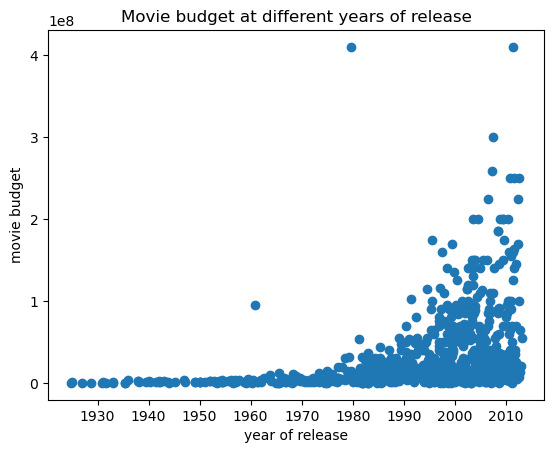

In [14]:
# Plot the movie budget at different years of release
plt.scatter(movie_features_no_outliers['movieReleaseDate'], movie_features_no_outliers['cost'])
plt.title('Movie budget at different years of release')
plt.xlabel('year of release')
plt.ylabel('movie budget')
plt.show()

First we can see two outliers in 1960 and 1979 that we still have to remove.

In [15]:
# Remove the two outliers
movie_features_no_outliers= movie_features_no_outliers[~movie_features_no_outliers['wikiPageID'].isin([1040518, 31556])]

We will use inflation rates per year which we got from the US inflation calculator.

In [16]:
# Importing inflation rates
inflation_rate = pd.read_csv(PATH + '/inflation_rates.csv', sep=';')
inflation_rate = inflation_rate.set_index('Year')

In [17]:
# Adjust the cost using inflation
def adjust_cost(row):

    release_year = row['movieReleaseDate'].year

    # Initialize the adjusted cost with the initial cost
    adjusted_cost = row['cost']
    
    # Iterate over the year of movie release to 2023
    for year in range(release_year, 2023):
        # Retrieve the inflation rate for the current year
        rate = inflation_rate.loc[year, 'Average']
        # Adjust the cost
        adjusted_cost *= (1 + rate / 100)
    return adjusted_cost

In [18]:
# Calculate the adjusted cost to each rows
adjusted_costs = movie_features_no_outliers.apply(adjust_cost, axis=1)

# Create a new dataset with adjusted costs
movie_features_adjusted = movie_features_no_outliers.copy()
movie_features_adjusted['cost'] = adjusted_costs

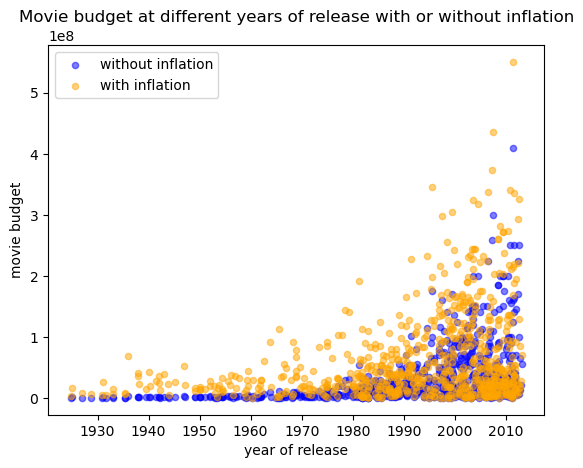

In [19]:
# Plot the budget before and after inflation adjustment
plt.scatter(movie_features_no_outliers['movieReleaseDate'], movie_features_no_outliers['cost'], label='without inflation', color='blue', alpha=0.5, s=20)
plt.scatter(movie_features_adjusted['movieReleaseDate'], movie_features_adjusted['cost'], label='with inflation', color='orange', alpha=0.5, s=20)
plt.title('Movie budget at different years of release with or without inflation')
plt.xlabel('year of release')
plt.ylabel('movie budget')
plt.legend()
plt.show()

### Separate in low and high budget categories

In [20]:
# Separate in low and high budget movies 

sorted_movie_features = movie_features_adjusted.sort_values('cost').copy()

# We will keep the 25% lowest and highest budget
lower_quartile = sorted_movie_features['cost'].quantile(0.25)
upper_quartile = sorted_movie_features['cost'].quantile(0.75)

low_budget= sorted_movie_features[sorted_movie_features['cost'] <= lower_quartile]
high_budget = sorted_movie_features[sorted_movie_features['cost'] >= upper_quartile]


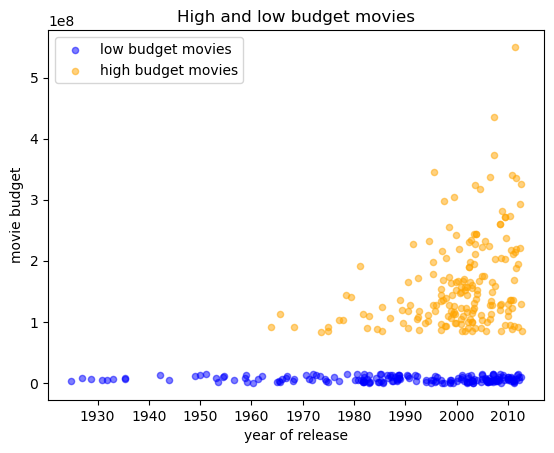

In [21]:
# Plot the budget separating low and high budget movies
plt.scatter(low_budget['movieReleaseDate'], low_budget['cost'], label='low budget movies', color='blue', alpha=0.5, s=20)
plt.scatter(high_budget['movieReleaseDate'], high_budget['cost'], label='high budget movies', color='orange', alpha=0.5, s=20)
plt.title('High and low budget movies')
plt.xlabel('year of release')
plt.ylabel('movie budget')
plt.legend()
plt.show()